### Run this notebook to familiarize yourself with the input data prior to running the regression analysis. 
### Investigate any potential data quality issues and move forward only when you are confident the data is correct.  
### Consider whether you want to run the regression analysis on daily data, weekly data, or both.

In [1]:
import os
import sys

In [2]:
sys.path.insert(0, os.path.join("..", ".."))
sys.path.append(os.path.join("..", "..", "impl", "lightweight_mmm"))

In [3]:
import numpy as np
import pandas as pd

In [4]:
from base_driver.config import load_config
from mmm.data.data_to_fit import DataToFit
from mmm.parser.csv import parse_csv_generic
from mmm.transform.transform import transform_input_generic

In [5]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [6]:
pd.options.display.float_format = '{:,.3f}'.format

#### Update `config_filename` and `input_filename` to refer to your config and data files.

In [7]:
config_filename = "../sample_config.yaml"
input_filename = "../sample_data.csv"

In [8]:
_, config = load_config(config_filename)
data_dict = parse_csv_generic(input_filename, config)
input_data = transform_input_generic(data_dict, config)
data_to_fit = DataToFit.from_input_data(input_data)

In [9]:
per_observation_df, _ = data_to_fit.to_data_frame(unscaled=True)

In [10]:
per_observation_df.head(5)

Ad Platform 1 volume  Ad Platform 2 volume  Ad Platform 3 volume  \
2023-01-01            18,391.000            20,079.002            19,621.000   
2023-01-02            20,391.998            19,307.000            19,490.000   
2023-01-03            21,157.000            18,604.000            20,310.000   
2023-01-04            19,782.000            20,753.000            19,784.000   
2023-01-05            18,710.000            19,716.000            20,815.002   

            Ad Platform 1 cost  Ad Platform 2 cost  Ad Platform 3 cost  \
2023-01-01             189.500             422.480             623.630   
2023-01-02             204.490             394.300             615.240   
2023-01-03             213.520             392.840             635.790   
2023-01-04             207.150             421.270             609.840   
2023-01-05             202.360             418.500             667.440   

            extra_feature_1    kpi  
2023-01-01            4.940 87.000  
2023-01-02            5.110 87.000  
2023-01-03            5.970 89.000  
2023-01-04            3.570 91.000  
2023-01-05            6.970 90.000

#### Review overall media spend

In [11]:
cost_cols = [col for col in per_observation_df.columns if col.endswith("cost")]
channel_sums = per_observation_df[cost_cols].sum(axis=0).to_frame()
channel_sums = channel_sums.rename(columns={channel_sums.columns[0]:"Total Cost"})
channel_sums["% of total"] = channel_sums / channel_sums.sum(axis=0)
channel_sums

Total Cost  % of total
Ad Platform 1 cost  24,651.790       0.167
Ad Platform 2 cost  49,232.590       0.333
Ad Platform 3 cost  73,950.890       0.500

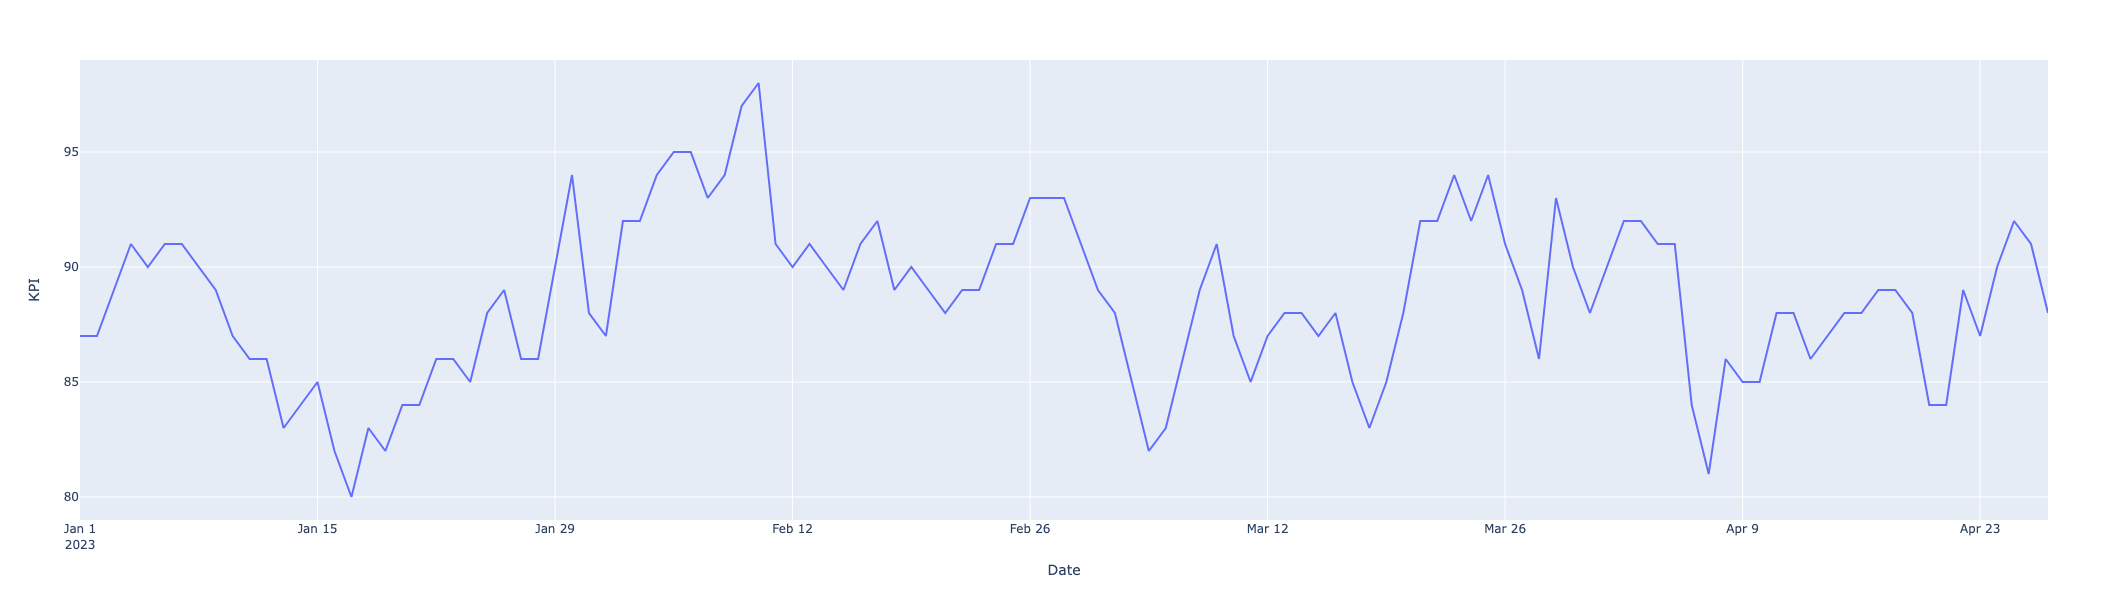

In [12]:
# Take a close look at the changes in the output metric over time. Think about whether things outside of marketing may
# account for big swings, and be mindful of this going into the analysis.
px.line(
    per_observation_df, 
    x=per_observation_df.index, 
    y=per_observation_df[input_data.target_name], 
    labels={"kpi":"KPI", "index":"Date"}, 
    height=600
)

#### Review overall distribution of values for input metrics and kpi.
#### The more observations (rows) there are for a particular value, the wider it will be in the violin chart.
#### Hover over the chart to see median and quantile values

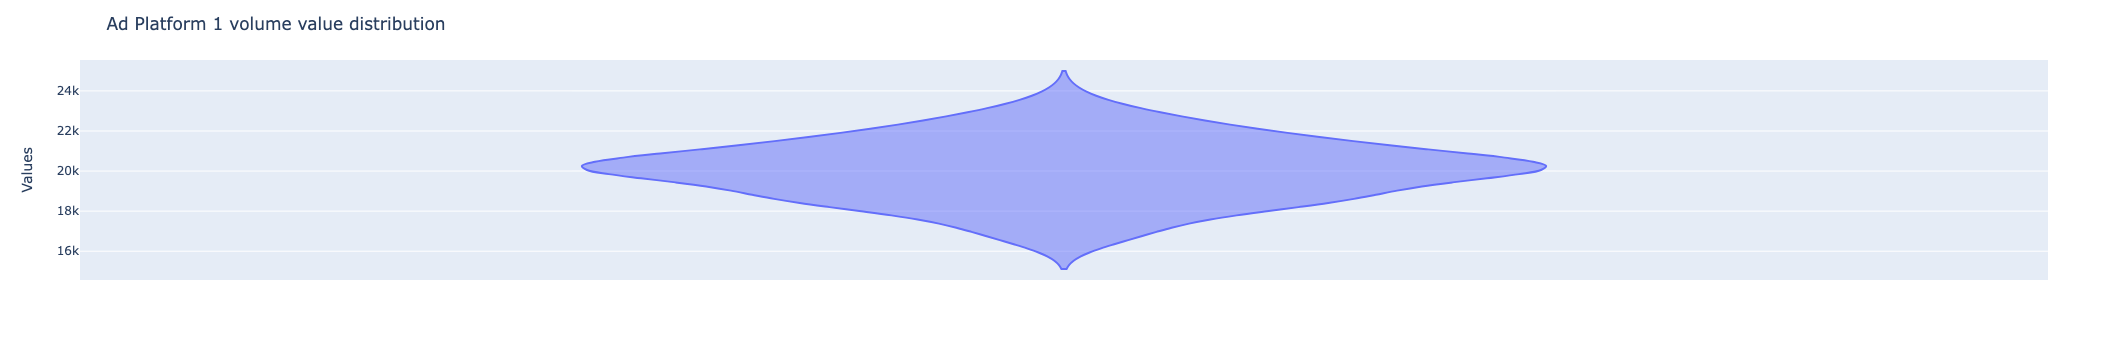

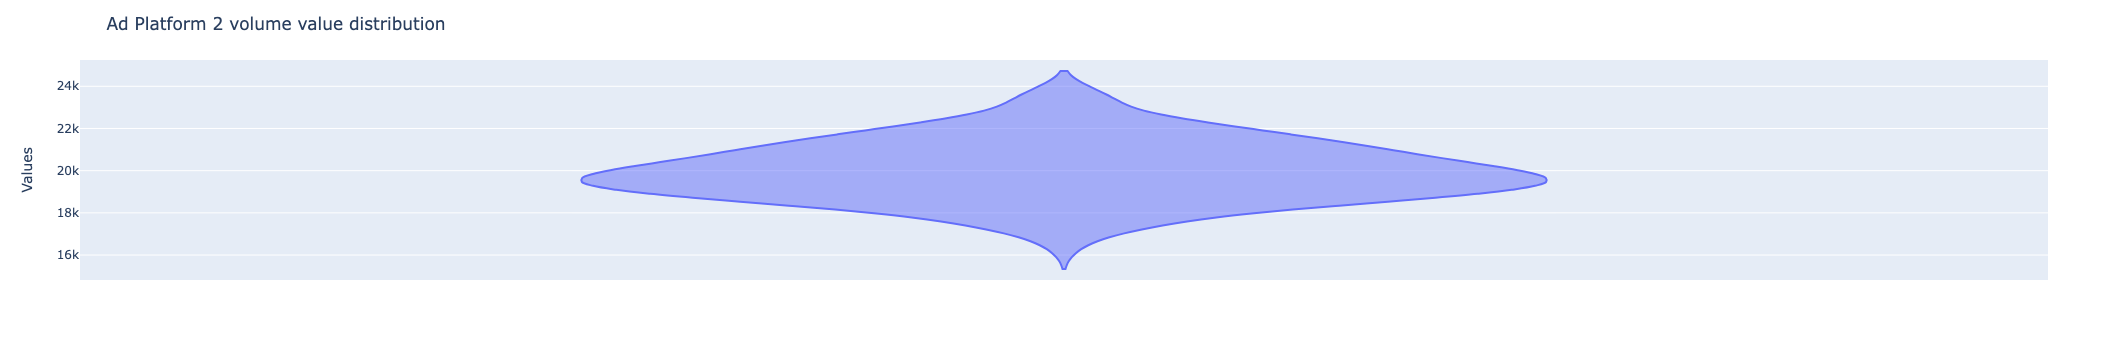

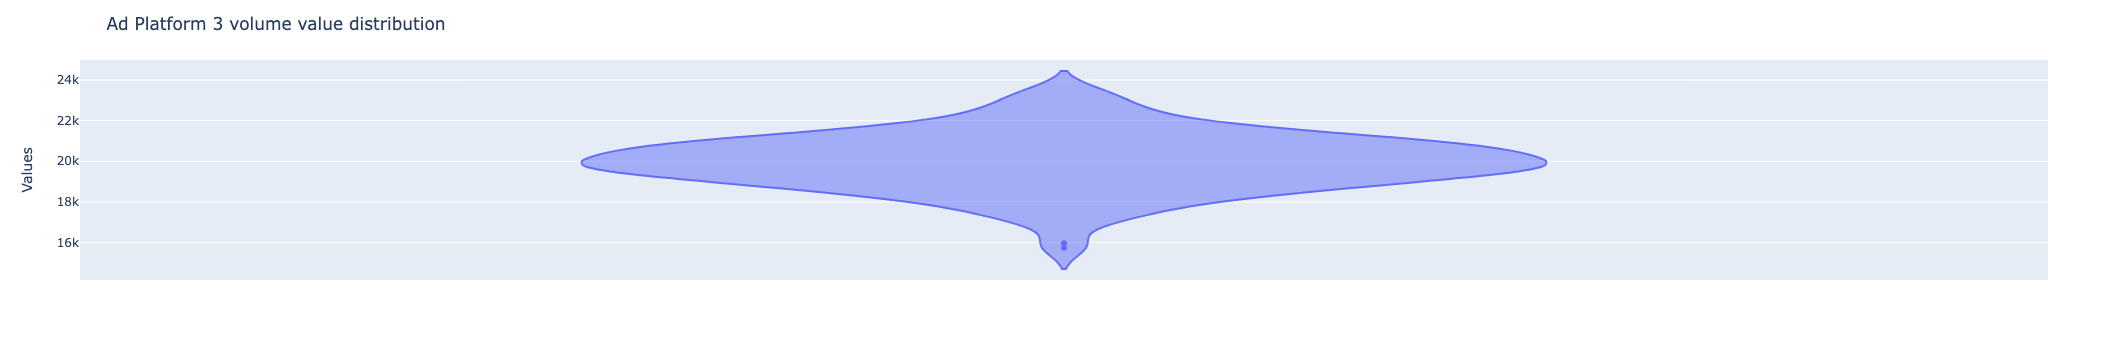

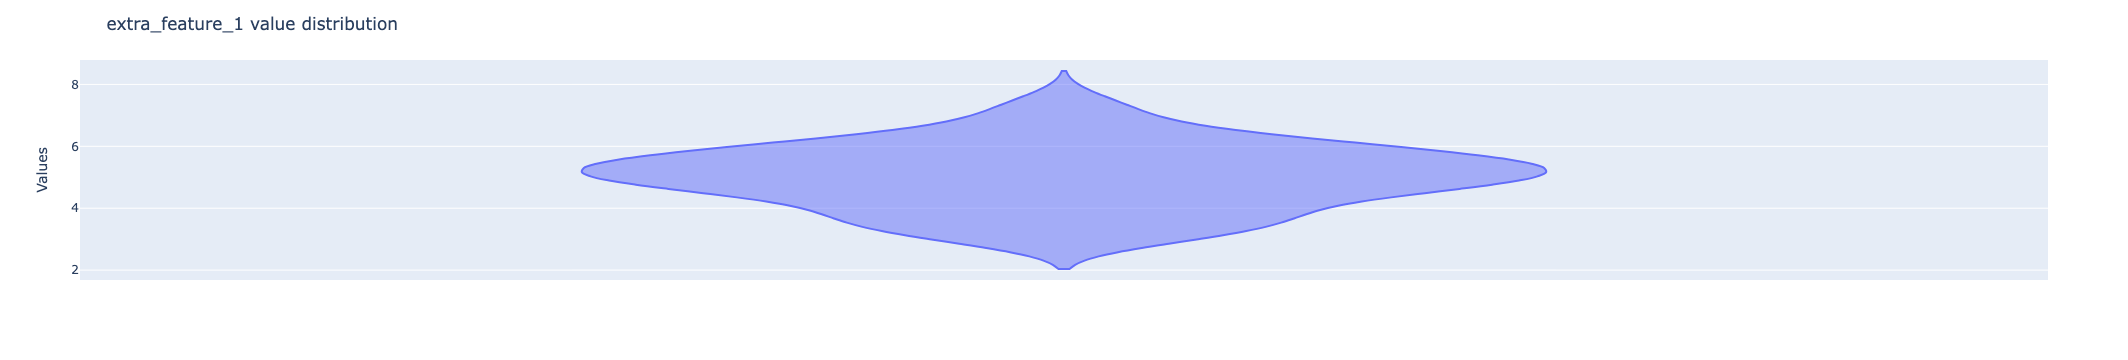

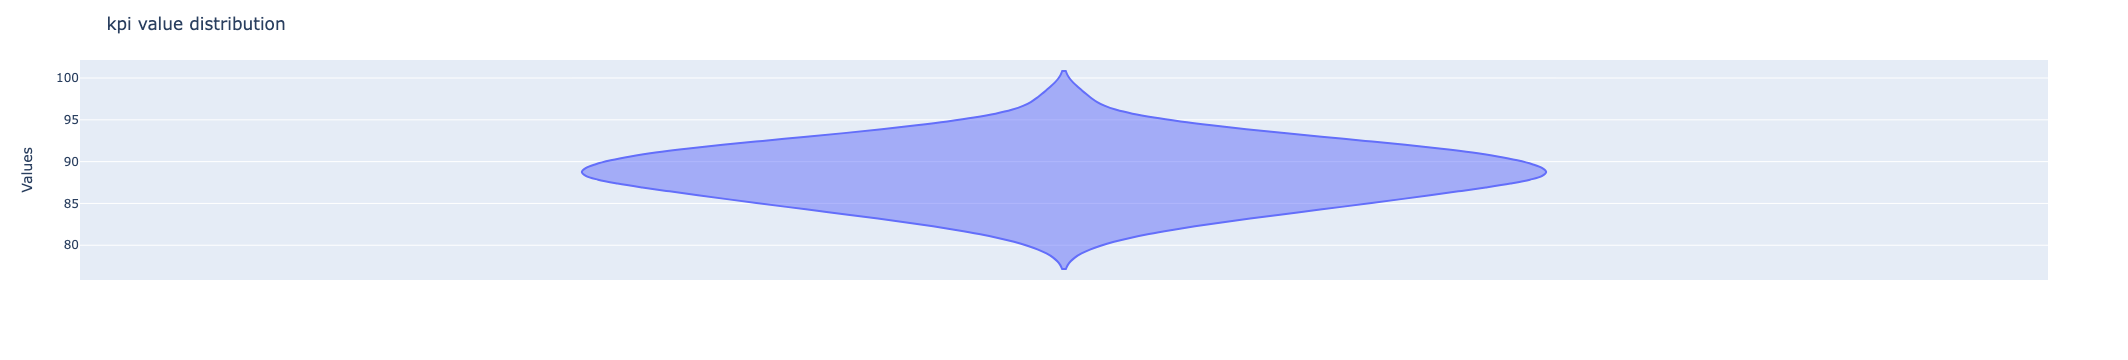

In [13]:
cols = [col for col in per_observation_df.columns if col.find("cost") == -1]
for col in cols:
    fig = px.violin(
        data_frame=per_observation_df,
        y=col,
    )
    
    # Update the figure layout
    fig.update_layout(
        title=f"{col} value distribution",
        xaxis_title="",
        yaxis_title="Values"
    )
    
    # Show the figure
    fig.show()

#### Review input metric trend lines.
#### Review the times the various lines increase and decrease to ensure they make sense.

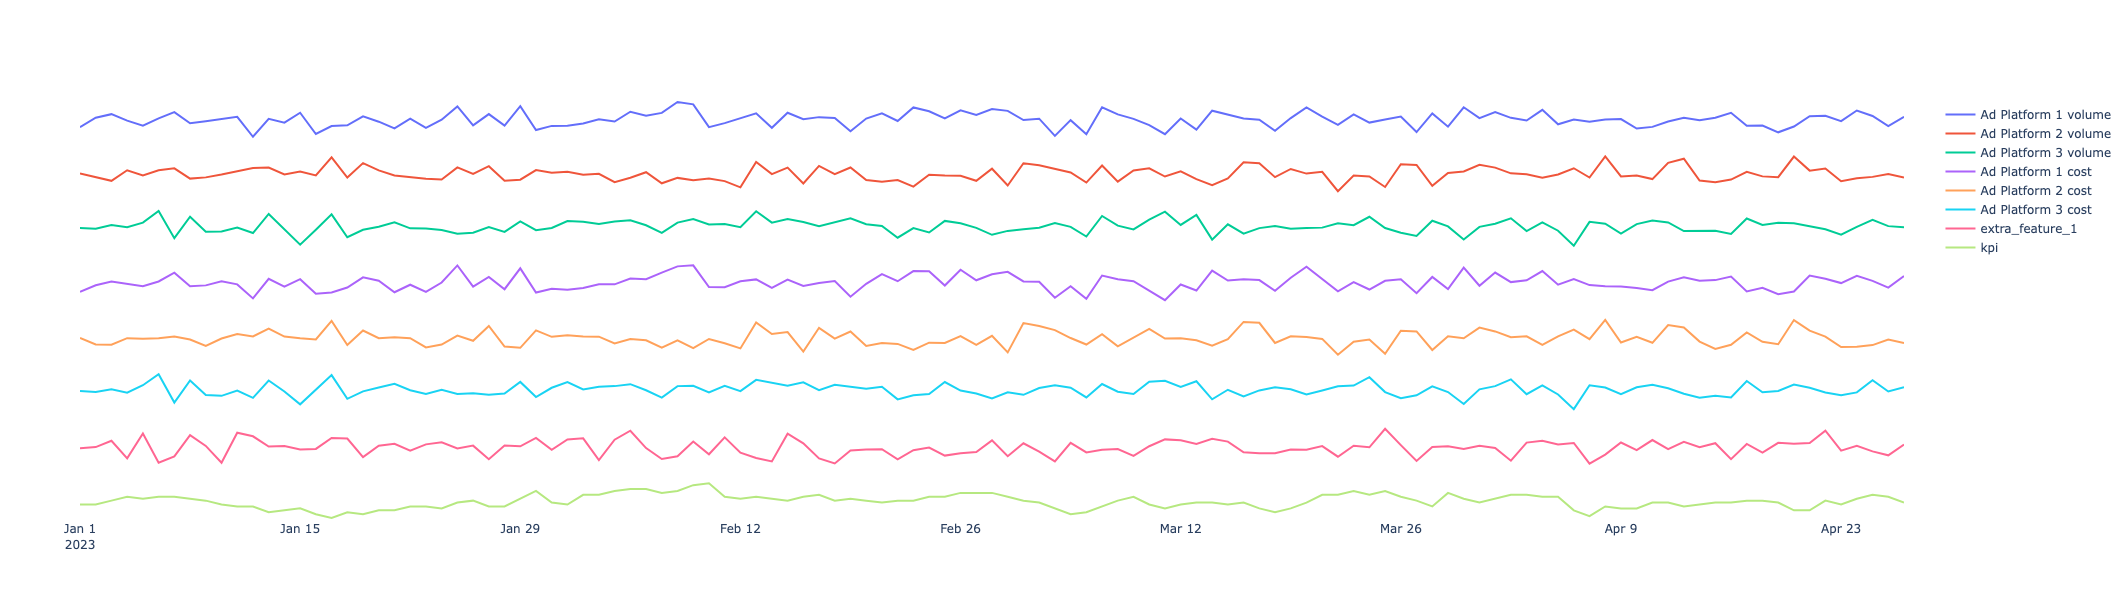

In [14]:
metrics = per_observation_df.columns
fig = make_subplots(rows=len(metrics),cols=1)
for idx, metric in enumerate(metrics):
    fig.add_trace(
        go.Scatter(
            x=per_observation_df.index, 
            y=per_observation_df[metric],
            mode='lines',
            name=metric
        ),
        row=idx + 1,
        col=1
    )
fig.update_xaxes(visible=False, fixedrange=False)
fig.update_xaxes(row=len(metrics), visible=True)
fig.update_yaxes(visible=False, fixedrange=False)
fig.update_layout(
    showlegend=True,
    plot_bgcolor="white",
    height=600
)
fig.show()

#### Same chart, but bigger

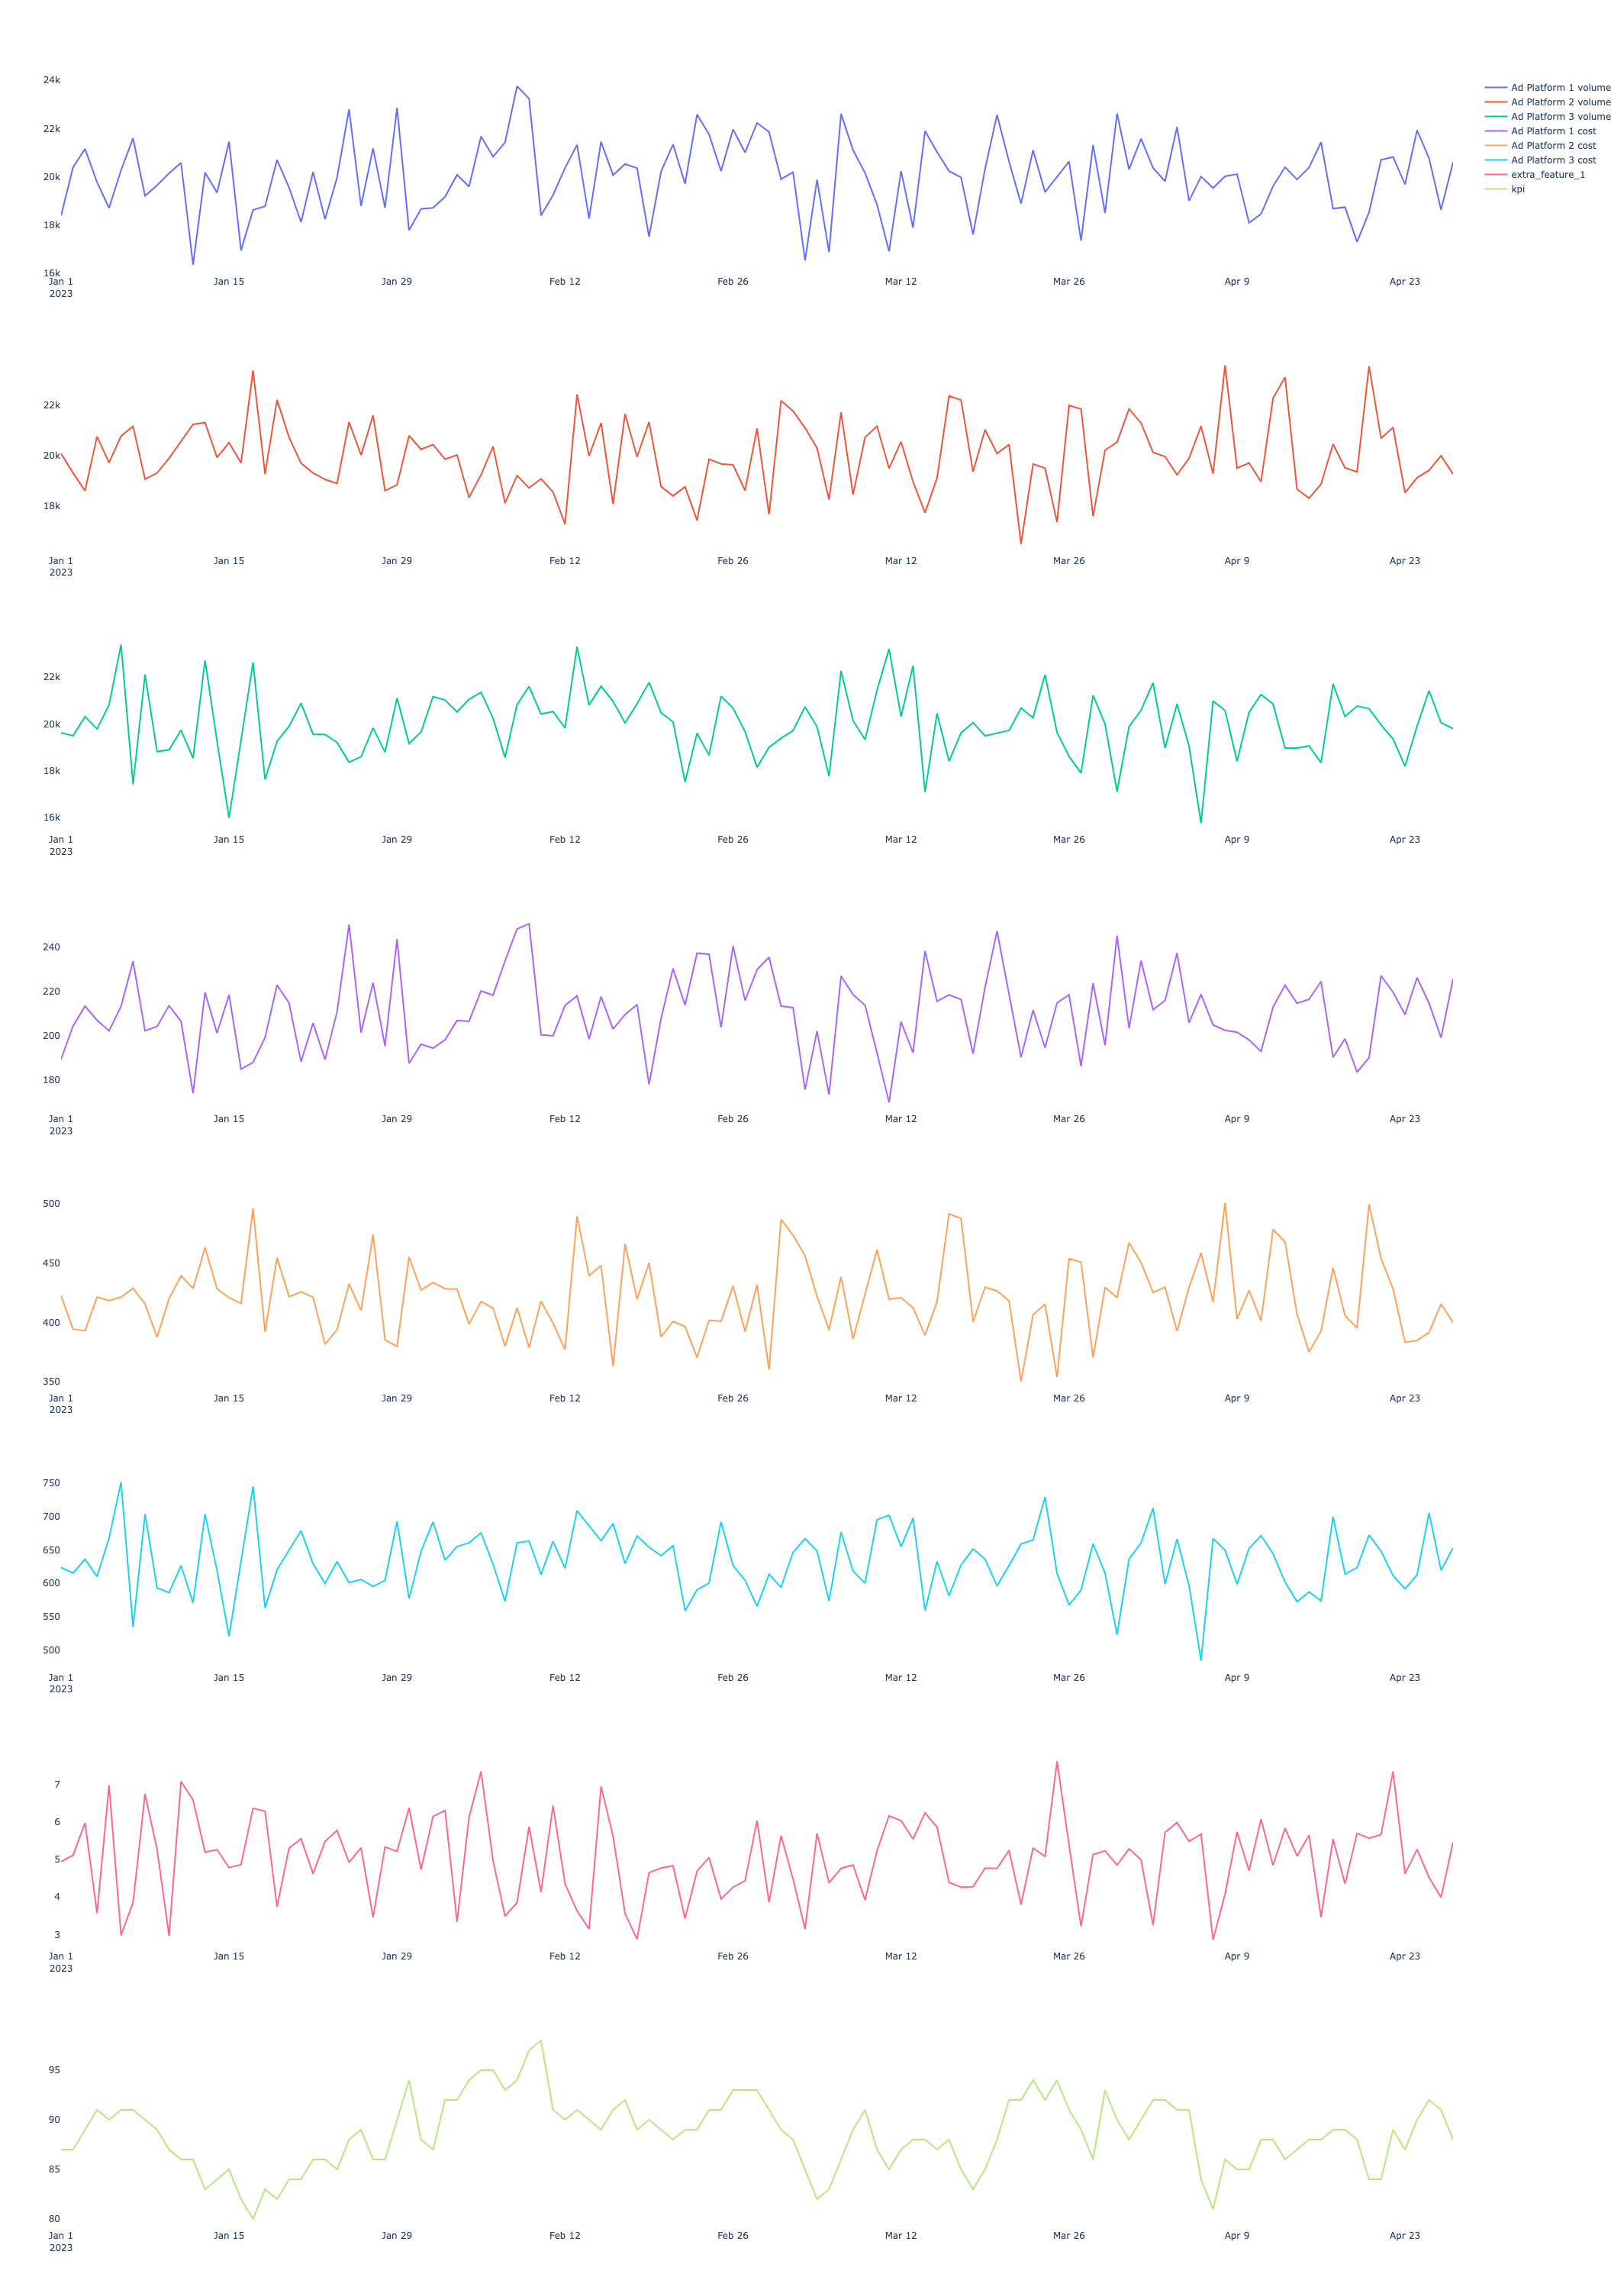

In [15]:
metrics = per_observation_df.columns
fig = make_subplots(rows=len(metrics),cols=1)
for idx, metric in enumerate(metrics):
    fig.add_trace(
        go.Scatter(
            x=per_observation_df.index, 
            y=per_observation_df[metric],
            mode='lines',
            name=metric
        ),
        row=idx + 1,
        col=1
    )
fig.update_layout(
    showlegend=True,
    plot_bgcolor="white",
    height=3000,
)
fig.show()

#### All impressions lines overlaid on top of each other

In [16]:
impressions_cols = [col for col in per_observation_df.columns if col.endswith("volume")]

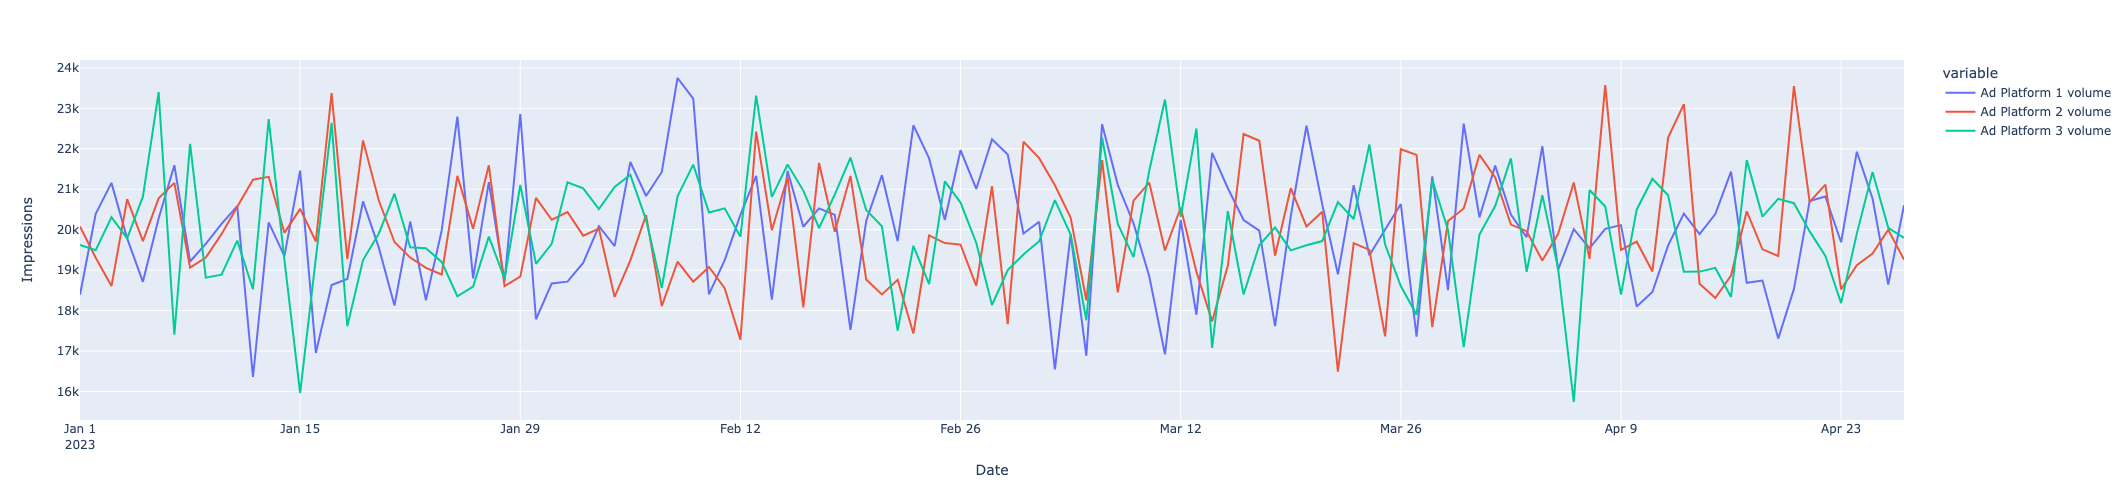

In [17]:
fig = px.line(per_observation_df[impressions_cols], labels={"index":"Date", "value":"Impressions"}, height=500)
fig.show()

#### All cost lines overlaid on top of each other

In [18]:
cost_cols = [col for col in per_observation_df.columns if col.endswith("cost")]

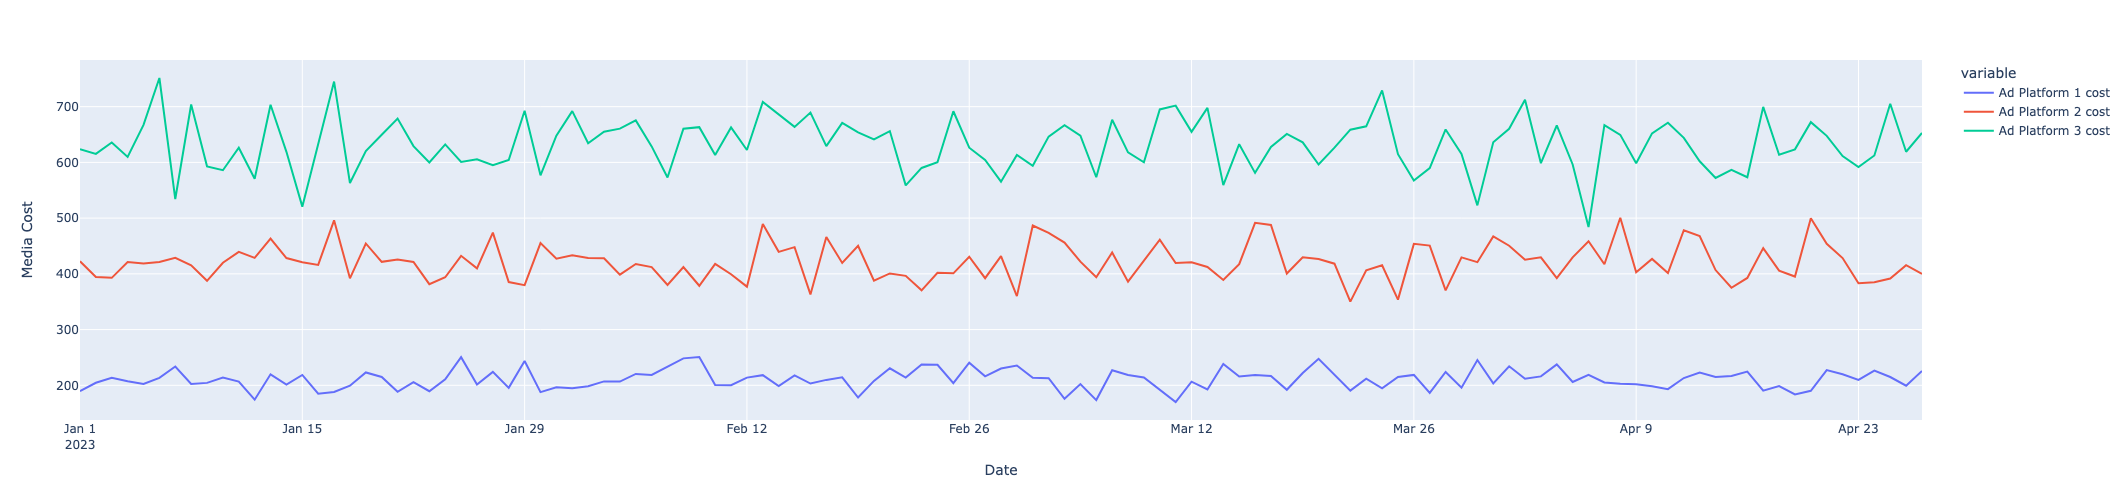

In [19]:
fig = px.line(per_observation_df[cost_cols], labels={"value":"Media Cost", "index":"Date"}, height=500)
fig.show()